In [1]:
import os
os.chdir('./../')

In [2]:
# Data
from folktables import ACSDataSource, ACSIncome, ACSMobility

# Wrangling
import numpy as np
import pandas as pd
import scipy.stats as scs

# Prep
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics

# NN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

# Viz 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
%load_ext autoreload
%autoreload 2
from main.models.modelarch import SampledMultitask
from main.models.datasamplers import TabularDataSet
from main.calibration.custommetrics import weighted_mse_loss
from main.calibration.fairness import get_fairness_objects, get_fair_estimation

In [4]:
device_ = 'cpu'

In [5]:
feature_df = pd.read_csv('../multifairness/data/prepared/folktabs/all_features.csv')
label_df = pd.read_csv('../multifairness/data/prepared/folktabs/all_labels.csv')

In [6]:
target_cols = ['PINCP', 'MIG']
numeric_cols = ['SCHL', 'WKHP', 'JWMNP']
other_cols = feature_df.drop(columns = numeric_cols).columns

In [7]:
multitask_model = SampledMultitask(input_dim=87, 
                                   output_1=1, 
                                   sampling_out_1=(0.25, 4.25),
                                   output_2=1,
                                   sampling_out_2=(5, 25),
                                   hidden_layer_architecture=[128,256,64],
                                   device=device_)

In [8]:
%%capture
multitask_model = multitask_model.to(device_)

In [9]:
# Encoders and pipeline
onehot_ = OneHotEncoder()
scaler_ = StandardScaler()

transformer = ColumnTransformer(
    transformers=[('categoricals', onehot_, other_cols), 
                  ('numerical', scaler_, numeric_cols)
                  ], 
                  remainder='passthrough', 
                  sparse_threshold=0)

# Split
X_train, X_test, y_train, y_test = train_test_split(feature_df,
                                                    label_df, 
                                                    test_size=0.3,
                                                    random_state=98765)

transformer.fit(X_train)
X_scaled = np.float32(transformer.transform(X_train))
X_test_scaled = np.float32(transformer.transform(X_test))


data_train = TabularDataSet(X_scaled,
                            np.float32(y_train.iloc[:,0]).reshape(-1,1),
                            np.float32(y_train.iloc[:,1]).reshape(-1,1))
data_test = TabularDataSet(X_test_scaled,
                           np.float32(y_test.iloc[:,0]).reshape(-1,1),
                           np.float32(y_test.iloc[:,1]).reshape(-1,1))

# Dataloaders
trainloader = DataLoader(data_train, batch_size=128, shuffle=True)
testloader = DataLoader(data_test, batch_size=128, shuffle=False)

In [10]:
%%capture
loss_per_iter = []
loss_per_batch = []

optimizer = optim.Adam(multitask_model.parameters(),
                       lr=0.001)

for epoch in range(75):
    multitask_model.train(True)
    running_loss = 0.0
    for i, (xval, y1, y2) in enumerate(trainloader):
        xval = xval.to(device_)
        y1 = y1.to(device_)
        y2 = y2.to(device_)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs1, outputs2, lambdas_ = multitask_model(xval.float())
        lambda0 = lambdas_[0].to(device_)
        lambda1 = lambdas_[1].to(device_)

        # need to set loss weights resulting from zero-loss observations to zero        
        weights_regression_task = torch.reshape(lambda0*y2, (-1,1))
        loss_fct_binary_task = nn.BCEWithLogitsLoss(weight=lambda1)
        
        loss_1 = weighted_mse_loss(outputs1,
                                   y1.float(),
                                   weights_regression_task)
        
        loss_2 = loss_fct_binary_task(outputs2, y2)
        
        # Combine losses and get gradient
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()

        # Save loss to plot
        running_loss += loss.item()
        loss_per_iter.append(loss.item())

    loss_per_batch.append(running_loss / (i + 1))
    running_loss = 0.0

multitask_model.train(False)

In [11]:
def calibrate_lambda_folk(model, validation_data, lambda_vals_):
    """
    lambda calibration
    """
    all_true_y1 = np.empty((0,1))
    all_true_y2 = np.empty((0,1))
    device_ = model.device

    with torch.no_grad():
        for i, (x_test, y1_test, y2_test) in enumerate(validation_data):
            all_true_y1 = np.concatenate([all_true_y1, y1_test.cpu().detach().numpy()])
            all_true_y2 = np.concatenate([all_true_y2, y2_test.cpu().detach().numpy()])

    t1_true = []
    t1_lambda = []
    t1_error = []
    t2_lambda = []

    for lambda_val in lambda_vals_:
        weight_check_1 = 1
        weight_check_2 = lambda_val

        all_preds_y1 = np.empty((0,1))
        all_preds_y2 = np.empty((0,1))

        with torch.no_grad():
            for i, (x_test, y1_test, y2_test) in enumerate(validation_data):
                
                weight_vector_1 = torch.ones((x_test.shape[0],1))*weight_check_1
                weight_vector_2 = torch.ones((x_test.shape[0],1))*weight_check_2

                test_lambda = [weight_vector_1, weight_vector_2]

                x_test = x_test.to(device_)
                preds_y1, preds_y2 = model(x_test, param_=test_lambda)
                preds_y2 = torch.sigmoid(preds_y2)

                # attach
                all_preds_y1 = np.concatenate([all_preds_y1, preds_y1.cpu().detach().numpy()])
                all_preds_y2 = np.concatenate([all_preds_y2, preds_y2.cpu().detach().numpy()])

                
        # Stats to select optimal lambda
        total_t1_sum = np.sum(all_true_y1)
        total_t1_sum_estim = np.sum(all_preds_y1)
        
        t1_true.append(float(total_t1_sum))
        t1_lambda.append(float(total_t1_sum_estim))
        t1_error.append(metrics.mean_squared_error(all_true_y1, all_preds_y1))

        # binary value
        total_t2_lambda_score = metrics.roc_auc_score(all_true_y2, all_preds_y2)

        t2_lambda.append(total_t2_lambda_score)


    return t1_true, t1_lambda, t1_error, t2_lambda

In [12]:
t1_true, t1_lambda, t1_error, t2_error = calibrate_lambda_folk(multitask_model, 
                                                               testloader, 
                                                               np.arange(0.25,25,0.25))

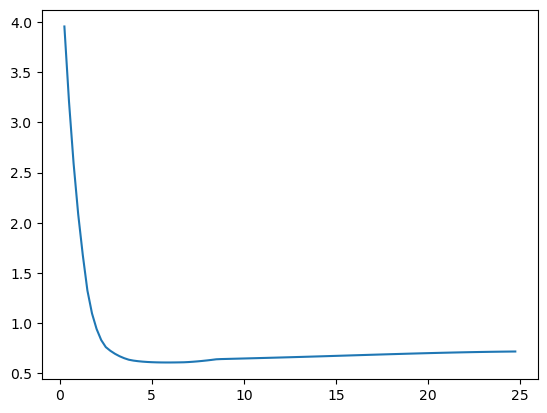

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(0.25,25,0.25), 
         t1_error)


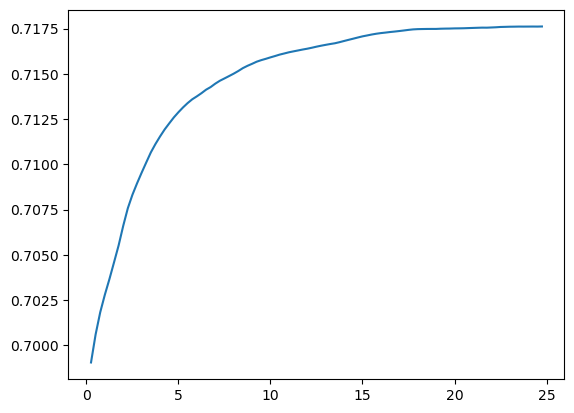

In [14]:
plt.plot(np.arange(0.25,25,0.25), 
         t2_error)

There is a tradeoff that flattens out at around 15, so lets try that $\lambda$

In [31]:
weight_check_1 = 1
weight_check_2 = 15

all_preds_y1 = np.empty((0,1))
all_preds_y2 = np.empty((0,1))
all_true_y1 = np.empty((0,1))
all_true_y2 = np.empty((0,1))


with torch.no_grad():
    for i, (x_test, y1_test, y2_test) in enumerate(testloader):
        
        weight_vector_1 = torch.ones((x_test.shape[0],1))*weight_check_1
        weight_vector_2 = torch.ones((x_test.shape[0],1))*weight_check_2

        test_lambda = [weight_vector_1, weight_vector_2]

        x_test = x_test.to(device_)
        preds_y1, preds_y2 = multitask_model(x_test, param_=test_lambda)
        preds_y2 = torch.sigmoid(preds_y2)

        # attach
        all_preds_y1 = np.concatenate([all_preds_y1, preds_y1.cpu().detach().numpy()])
        all_preds_y2 = np.concatenate([all_preds_y2, preds_y2.cpu().detach().numpy()])

        all_true_y1 = np.concatenate([all_true_y1, y1_test.cpu().detach().numpy()])
        all_true_y2 = np.concatenate([all_true_y2, y2_test.cpu().detach().numpy()])

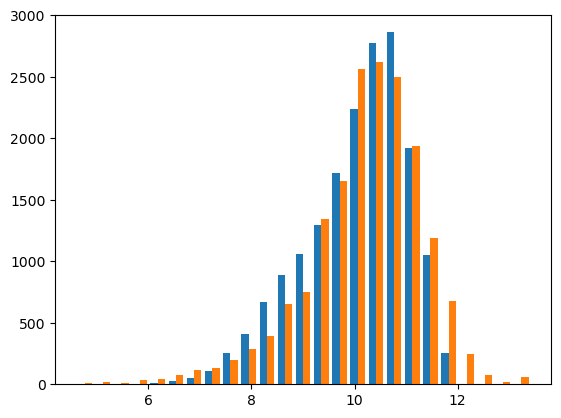

In [32]:
plt.hist([all_preds_y1.reshape(-1,),
          all_true_y1.reshape(-1,)], 
         bins=25)
plt.show()

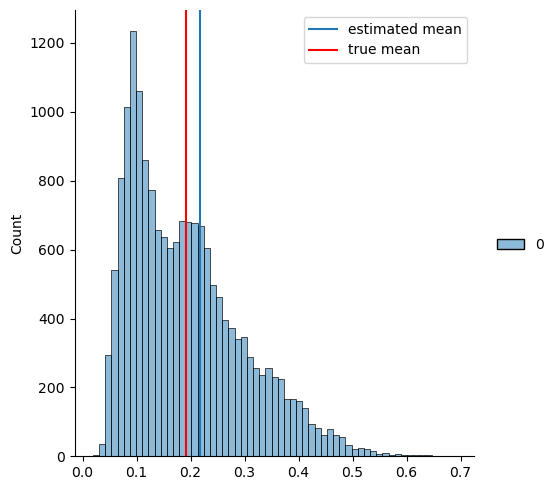

In [33]:
sns.displot(all_preds_y2)
plt.axvline(all_true_y2.mean(), 0,650, label='estimated mean')
plt.axvline(all_preds_y2.mean(), 0,650, color='red', label='true mean')
plt.legend()

In [34]:
weight_check_1 = 1
weight_check_2 = 15

sensitive_ = X_scaled[:,5] == 0.0
sensitive_test = X_test_scaled[:,5] == 0.0
sensitive_tensor = torch.from_numpy(X_scaled[sensitive_, :]).to(device_)
nonsensitive_tensor = torch.from_numpy(X_scaled[~sensitive_, :]).to(device_)

# sensitive
weight_vector_1 = torch.ones((sensitive_tensor.shape[0],1))*weight_check_1
weight_vector_2 = torch.ones((sensitive_tensor.shape[0],1))*weight_check_2
weight_vector_1 = weight_vector_1.to(device_)
weight_vector_2 = weight_vector_2.to(device_)
test_lambda = [weight_vector_1, weight_vector_2]

preds_y1_sens, preds_y2_sens = multitask_model(sensitive_tensor, param_=test_lambda)
try:
    preds_y1_sens = preds_y1_sens.detach().numpy()
    preds_y2_sens = torch.sigmoid(preds_y2_sens).detach().numpy()
except TypeError:
    preds_y1_sens = preds_y1_sens.cpu().detach().numpy()
    preds_y2_sens = torch.sigmoid(preds_y2_sens).cpu().detach().numpy()

# nonsensitive
weight_vector_1 = torch.ones((nonsensitive_tensor.shape[0],1))*weight_check_1
weight_vector_2 = torch.ones((nonsensitive_tensor.shape[0],1))*weight_check_2
weight_vector_1 = weight_vector_1.to(device_)
weight_vector_2 = weight_vector_2.to(device_)
test_lambda = [weight_vector_1, weight_vector_2]

preds_y1_nonsens, preds_y2_nonsens = multitask_model(nonsensitive_tensor, param_=test_lambda)
try:
    preds_y1_nonsens = preds_y1_nonsens.detach().numpy()
    preds_y2_nonsens = torch.sigmoid(preds_y2_nonsens).detach().numpy()
except TypeError:
    preds_y1_nonsens = preds_y1_nonsens.cpu().detach().numpy()
    preds_y2_nonsens = torch.sigmoid(preds_y2_nonsens).cpu().detach().numpy()

p1, e1, q1, = get_fairness_objects(sensitive_, 
                                    preds_y1_nonsens, 
                                    preds_y1_sens)

p2, e2, q2, = get_fairness_objects(sensitive_, 
                                    preds_y2_nonsens, 
                                    preds_y2_sens)

# convert to fair estimation 
preds_y1_sens_test = all_preds_y1[sensitive_test]
preds_y1_nonsens_test = all_preds_y1[~sensitive_test]

preds_y2_sens_test = all_preds_y2[sensitive_test]
preds_y2_nonsens_test = all_preds_y2[~sensitive_test]

fair_nonsensitive_y1, fair_sensitive_y1 = get_fair_estimation(p1, e1, q1, 
                                                              preds_y1_nonsens_test.reshape(-1,),
                                                              preds_y1_sens_test.reshape(-1,))

fair_nonsensitive_y2, fair_sensitive_y2 = get_fair_estimation(p2, e2, q2, 
                                                              preds_y2_nonsens_test.reshape(-1,),
                                                              preds_y2_sens_test.reshape(-1,))

fair_vec_1 = np.zeros(shape=(len(sensitive_test), ))
fair_vec_1[~sensitive_test] = fair_nonsensitive_y1
fair_vec_1[sensitive_test] = fair_sensitive_y1

fair_vec_2 = np.zeros(shape=(len(sensitive_test), ))
fair_vec_2[~sensitive_test] = fair_nonsensitive_y2
fair_vec_2[sensitive_test] = fair_sensitive_y2


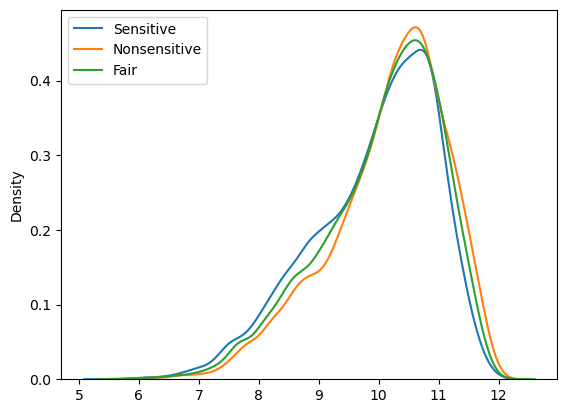

In [35]:
sns.kdeplot(preds_y1_sens_test.reshape(-1,), label='Sensitive')
sns.kdeplot(preds_y1_nonsens_test.reshape(-1,), label='Nonsensitive')
sns.kdeplot(fair_vec_1.reshape(-1,), label='Fair')
plt.legend();